In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import norm 

In [3]:
from datetime import datetime, time
import pandas_datareader.data as pdr
import yfinance as yf

In [60]:
def black_scholes(s, k, r, t, sigma, option_type):
    T = t/252  #daily to yearly 
    d1 = (np.log(s/k) + ((r + sigma**2)/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    n_d1 = norm.cdf(-d1)
    n_d2 = norm.cdf(-d2)
    
    
   
    if option_type == 'Call':
        value = norm.cdf(d1) * s - norm.cdf(d2) * k * np.exp(-r*T)
        #return c
    else:
        value =  k * np.exp(-r *t)* n_d2 - s * n_d1
        #return p
    
    #delta
    if option_type == 'Call' : delta = norm.cdf(d1) 
    else:  delta = norm.cdf(d1) -1
    
    #gamma
    gamma = norm.pdf(d1) /(s * sigma * np.sqrt(T))
    
    #theta
    if option_type =='Call':
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T))) - r * k *np.exp(-r*T)*norm.cdf(d2)
    else:
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T))) + r * k* np.exp(-r*T)*n_d2
    
    #vega
    vega = s* np.sqrt(T) * norm.pdf(d1)
    
    #rho
    if option_type == 'Call':
        rho = k * T * np.exp(-r*T)*norm.cdf(d2)
    else:
        rho = -(k * T * np.exp(-r*T)*n_d2)
    
    option_values = {
        "option_type" : option_type,
        "premium" : value.round(4),  "detla" :  delta.round(4), "gamma" : gamma.round(4), 
        "theta" : theta.round(4), "vega" : vega.round(4),'rho' :  rho.round(4)       
    }
    
    return option_values

##### Ticker and expiry date

In [38]:
ticker = 'QCOM'
expiry_date = '12-15-2023'


In [39]:
today = datetime.now().date()
one_year_ago = today.replace(year = today.year-1)

In [8]:
stock = yf.Ticker(ticker)
df = yf.download(ticker,start = one_year_ago, end = today,rounding = True )


[*********************100%***********************]  1 of 1 completed


In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-15,125.65,128.13,123.42,126.02,122.73,12470200
2022-11-16,123.20,123.84,119.96,120.73,117.58,9561700
2022-11-17,118.95,123.12,118.71,122.86,119.66,7273700
2022-11-18,124.04,124.49,122.13,123.85,120.62,6436600
2022-11-21,121.09,122.50,120.10,120.20,117.07,8204200


In [10]:
df_1 = df['Adj Close']
df_returns = df_1.to_frame()

In [12]:
#calculating returns
df_returns['returns'] = df['Adj Close'].pct_change()

In [13]:
df_returns['cum_ret'] = (df_returns['returns'] +1).cumprod()


In [14]:
df_returns.dropna().head()

,Adj Close,returns,cum_ret
Date,,,
2022-11-16,117.58,-0.041962,0.958038
2022-11-17,119.66,0.017690,0.974986
2022-11-18,120.62,0.008023,0.982808
2022-11-21,117.07,-0.029431,0.953883
2022-11-22,120.43,0.028701,0.981260


In [15]:
log_returns = np.log(df['Close']/df['Close'].shift(1)).dropna()


In [16]:
df_returns['log_returns'] = log_returns
df_returns.tail()

,Adj Close,returns,cum_ret,log_returns
Date,,,,
2023-11-09,120.10,0.000333,0.978571,0.000333
2023-11-10,124.21,0.034221,1.012059,0.033649
2023-11-13,123.85,-0.002898,1.009126,-0.002903
2023-11-14,127.36,0.028341,1.037725,0.027947
2023-11-15,128.92,0.012249,1.050436,0.012174


#### Plotting returns

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

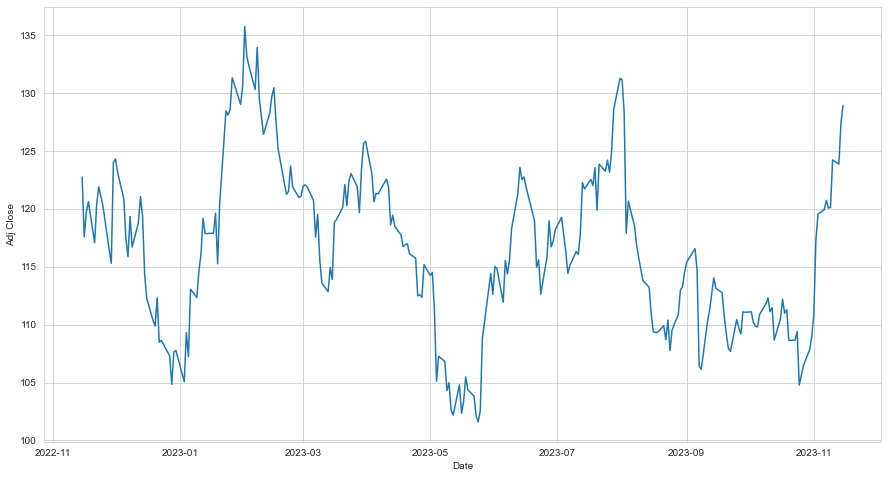

In [19]:
#Visualize the price
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['Adj Close'] )

<AxesSubplot:xlabel='Date', ylabel='log_returns'>

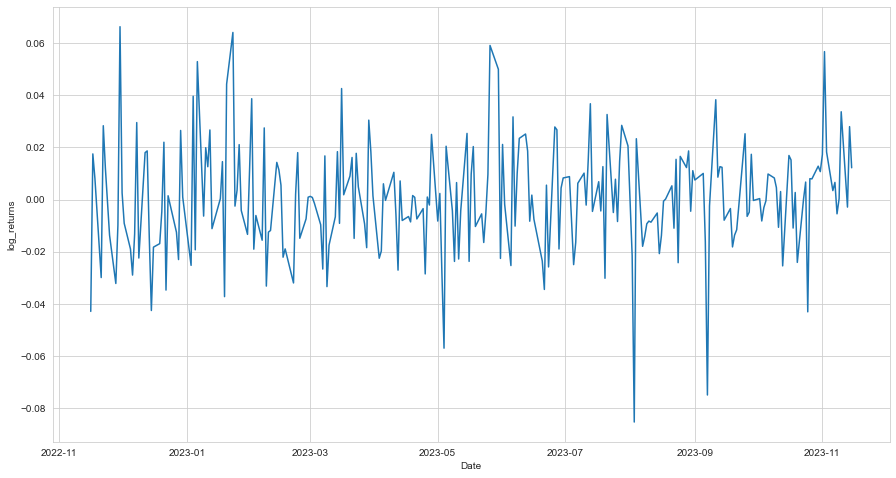

In [21]:
#Visualizing log return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['log_returns'])

<AxesSubplot:xlabel='returns', ylabel='Count'>

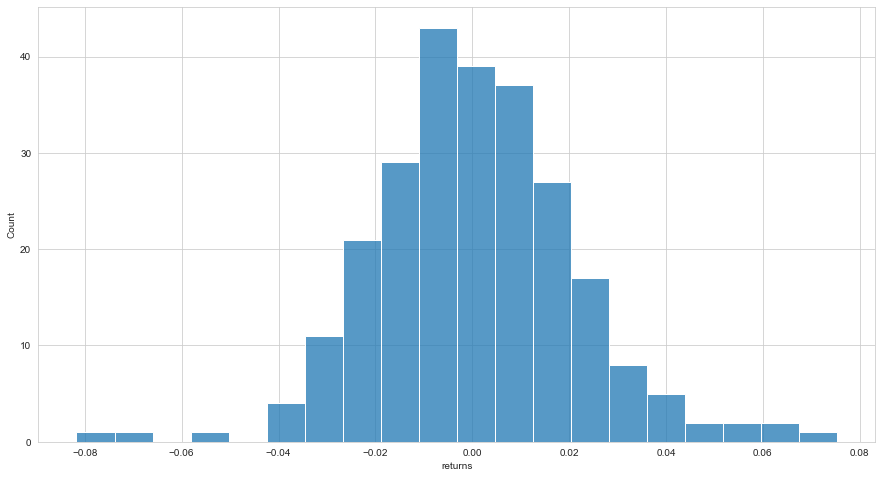

In [25]:
#Visualizing return
plt.figure(figsize=(15,8))
sns.histplot(data = df_returns['returns'])

##### Sigma 

In [26]:
sigma = np.sqrt(252)*df_returns['log_returns'].std()
sigma

0.33807425786977313

In [27]:
sigma_ret = np.sqrt(252)*df_returns['returns'].std()
sigma_ret

0.33927107377453064

#### Risk-free rate

In [28]:
#risk-free rate, as the 10-year U.S. treasury yield which could get from ^TNX
r = yf.download('^IRX', rounding=True)['Adj Close'].tail(1)/100
r = r.values[0]
r

[*********************100%***********************]  1 of 1 completed


0.0526

#### Current stock price

In [40]:
#current stock price
s = df_returns['Adj Close'].iloc[-1]
s

128.92

#### Time

In [44]:
# time remaining untill expiration in days
t = (datetime.strptime(expiry_date, "%m-%d-%Y") - datetime.utcnow()).days 
t

28

#### Strike price

In [58]:
strike_price = 130


#### Calculating option value

In [61]:
black_scholes(s, strike_price, r, t, sigma,'Call')

{'option_type': 'Call',
 'premium': 5.6383,
 'detla': 0.5033,
 'gamma': 0.0275,
 'theta': -29.197,
 'vega': 17.1433,
 'rho': 6.5829}